<a href="https://colab.research.google.com/github/giuseppe-iacono-eng/telco-churn-prediction/blob/main/02_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Shared project folder on Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os, pathlib
BASE_DIR = "/content/drive/MyDrive/colab_data/telco-churn"   # change if you like
DATA_DIR = f"{BASE_DIR}/data"
ARTIFACTS_DIR = f"{BASE_DIR}/artifacts"
pathlib.Path(DATA_DIR).mkdir(parents=True, exist_ok=True)
pathlib.Path(ARTIFACTS_DIR).mkdir(parents=True, exist_ok=True)

RAW_PATH   = f"{DATA_DIR}/telco_raw.csv"
CLEAN_PATH = f"{DATA_DIR}/telco_clean.csv"
MODEL_PATH = f"{ARTIFACTS_DIR}/model.joblib"

Mounted at /content/drive


Mounted at /content/drive
Logistic ROC-AUC: 0.842
XGBoost ROC-AUC: 0.832
Chosen threshold (recall>=0.80): 0.211
              precision    recall  f1-score   support

           0      0.909     0.712     0.798      1035
           1      0.502     0.802     0.617       374

    accuracy                          0.736      1409
   macro avg      0.705     0.757     0.708      1409
weighted avg      0.801     0.736     0.750      1409



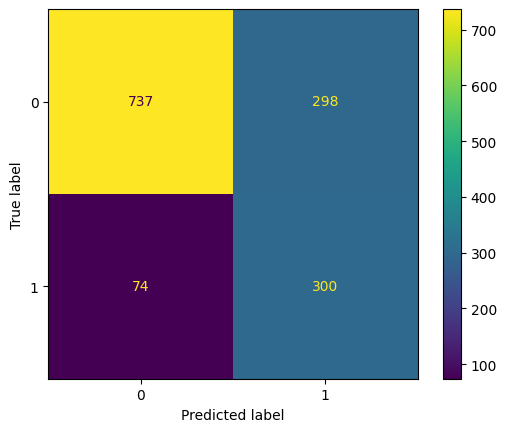

✅ Saved model pipeline to: /content/drive/MyDrive/colab_data/telco-churn/artifacts/model.joblib


In [3]:
# ==== Shared Drive header (same in every notebook) ====
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os, pathlib
BASE_DIR = "/content/drive/MyDrive/colab_data/telco-churn"   # change if you like
DATA_DIR = f"{BASE_DIR}/data"
ARTIFACTS_DIR = f"{BASE_DIR}/artifacts"
pathlib.Path(DATA_DIR).mkdir(parents=True, exist_ok=True)
pathlib.Path(ARTIFACTS_DIR).mkdir(parents=True, exist_ok=True)

CLEAN_PATH = f"{DATA_DIR}/telco_clean.csv"
MODEL_PATH = f"{ARTIFACTS_DIR}/model.joblib"

# ==== Install deps ====
!pip -q install xgboost

# ==== Imports ====
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score, precision_recall_curve, classification_report,
    ConfusionMatrixDisplay
)
from xgboost import XGBClassifier
import joblib

# ==== Load clean data ====
assert os.path.exists(CLEAN_PATH), f"Clean file not found: {CLEAN_PATH}. Run 01_eda.ipynb first."
df = pd.read_csv(CLEAN_PATH)
y = df["Churn"]
X = df.drop(columns=["Churn"])

num_cols = X.select_dtypes(include=np.number).columns.tolist()
cat_cols = X.select_dtypes(exclude=np.number).columns.tolist()

pre = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
])

Xtr, Xte, ytr, yte = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# ==== Baseline: Logistic Regression ====
logit = Pipeline([("prep", pre), ("clf", LogisticRegression(max_iter=1000))])
logit.fit(Xtr, ytr)
proba_log = logit.predict_proba(Xte)[:, 1]
print("Logistic ROC-AUC:", round(roc_auc_score(yte, proba_log), 3))

# ==== Stronger: XGBoost ====
xgb = Pipeline([
    ("prep", pre),
    ("clf", XGBClassifier(
        n_estimators=400, max_depth=6, learning_rate=0.05,
        subsample=0.9, colsample_bytree=0.9,
        eval_metric="logloss", random_state=42
    ))
])
xgb.fit(Xtr, ytr)
proba_xgb = xgb.predict_proba(Xte)[:, 1]
print("XGBoost ROC-AUC:", round(roc_auc_score(yte, proba_xgb), 3))

# ==== Business threshold: recall >= 0.80, maximize precision ====
prec, rec, thr = precision_recall_curve(yte, proba_xgb)

# Align lengths: thresholds has length n, precision/recall have length n+1
prec_t = prec[:-1]
rec_t  = rec[:-1]

target_recall = 0.80
mask = rec_t >= target_recall

if mask.any():
    best_i = np.argmax(prec_t[mask])          # index inside masked arrays
    best_thr = thr[mask][best_i]              # pick threshold matching that point
else:
    # fallback if model cannot reach desired recall
    best_thr = 0.5

pred = (proba_xgb >= best_thr).astype(int)

print("Chosen threshold (recall>=0.80):", round(float(best_thr), 3))
print(classification_report(yte, pred, digits=3))
ConfusionMatrixDisplay.from_predictions(yte, pred)
plt.show()

# ==== Save best pipeline ====
joblib.dump(xgb, MODEL_PATH)
print("✅ Saved model pipeline to:", MODEL_PATH)

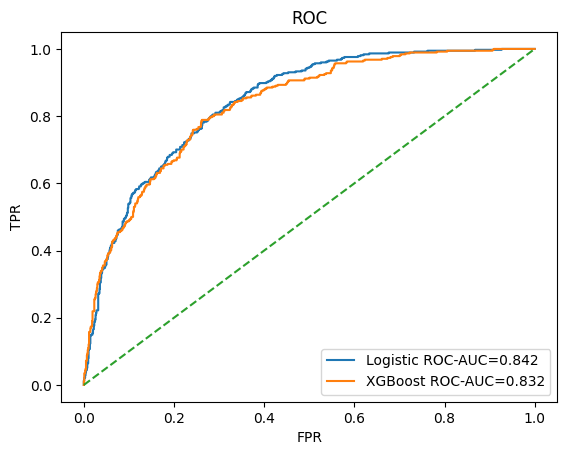

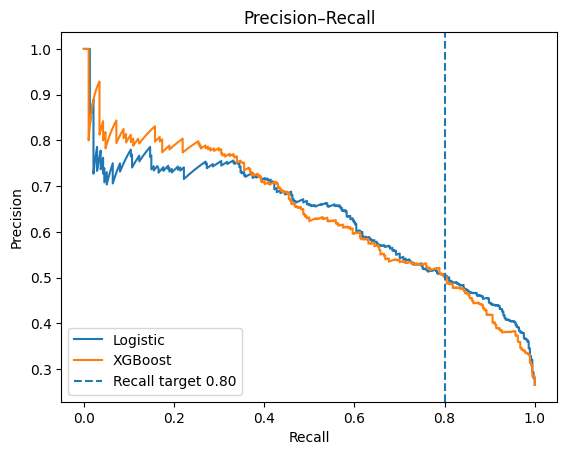

In [4]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt

# ROC curves
fpr_log, tpr_log, _ = roc_curve(yte, proba_log)
fpr_xgb, tpr_xgb, _ = roc_curve(yte, proba_xgb)
plt.plot(fpr_log, tpr_log, label=f"Logistic ROC-AUC={auc(fpr_log, tpr_log):.3f}")
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost ROC-AUC={auc(fpr_xgb, tpr_xgb):.3f}")
plt.plot([0,1],[0,1],'--')
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC"); plt.legend(); plt.show()

# Precision–Recall curves
prec_log, rec_log, _ = precision_recall_curve(yte, proba_log)
prec_xgb, rec_xgb, _ = precision_recall_curve(yte, proba_xgb)
plt.plot(rec_log, prec_log, label="Logistic")
plt.plot(rec_xgb, prec_xgb, label="XGBoost")
plt.axvline(0.80, ls="--", label="Recall target 0.80")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precision–Recall"); plt.legend(); plt.show()
